In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy

### Set up directory
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from tqdm import tqdm

import gymnasium as gym

from llama import get_model_and_tokenizer

In [2]:
model, tokenizer = get_model_and_tokenizer('7b')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## RL helper functions

In [3]:
from rl_utils import gym_generate_random_policy, load_offline_dataset, make_RL_time_serie, icl_prediction, compute_statistics, to_plot_stats 

## Generate RL series

In [22]:
N = 500
env_name = 'HalfCheetah'
policy = 'expert'  # 'expert' or 'random'

# get features names
data_path = "/home/abenechehab/d4rl_halfcheetah/d4rl_expert_80k_20k/X_test.csv"
_, columns, _, _ = load_offline_dataset(path=data_path)
print(f"columns: {columns}")

# -------------------- Build data from env or from offline dataset --------------------
if policy=='random':
    X, N_observations, N_actions = gym_generate_random_policy(Number_of_steps=N, env_name=env_name)
elif policy=='expert':
    X, _, N_observations, N_actions = load_offline_dataset(path=data_path)
    print(f"columns: {columns}")
else:
    raise ValueError(f"policy {policy} not supported!")

dim_list = [0]
# dim_list = np.arange(0,17)
all_dim = False
for dim in dim_list:
    # -------------------- Make RL time serie --------------------
    series_dict, N_dim = make_RL_time_serie(
        X=X, 
        N_observations=N_observations, 
        N_actions=N_actions, 
        Number_of_steps=N,
        all_dim=all_dim, 
        dim=dim, 
        add_actions=False, 
        add_reward=False,
        traj_starting_idx=0,
    )
    
    # -------------------- ICL prediction using llama3 --------------------
    series_dict = icl_prediction(model=model, tokenizer=tokenizer, series_dict=series_dict, temperature=0.5)
    
    # -------------------- Compute statistics of next state --------------------
    statistics = compute_statistics(
        series_dict=series_dict,
    )

columns: Index(['rootz', 'rooty', 'bthigh', 'bshin', 'bfoot', 'fthigh', 'fshin',
       'ffoot', 'rootx_dot', 'rootz_dot', 'rooty_dot', 'bthigh_dot',
       'bshin_dot', 'bfoot_dot', 'fthigh_dot', 'fshin_dot', 'ffoot_dot',
       'obs_reward', 't_bthigh', 't_bshin', 't_bfoot', 't_fthigh', 't_fshin',
       't_ffoot', 'reward', 'restart', 'epoch_id'],
      dtype='object')
columns: Index(['rootz', 'rooty', 'bthigh', 'bshin', 'bfoot', 'fthigh', 'fshin',
       'ffoot', 'rootx_dot', 'rootz_dot', 'rooty_dot', 'bthigh_dot',
       'bshin_dot', 'bfoot_dot', 'fthigh_dot', 'fshin_dot', 'ffoot_dot',
       'obs_reward', 't_bthigh', 't_bshin', 't_bfoot', 't_fthigh', 't_fshin',
       't_ffoot', 'reward', 'restart', 'epoch_id'],
      dtype='object')
sample before rescale: [[0.01179651]]
sample after rescale: [[0.78712382]]
full_series: 700,688,59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 7116.56it/s]
/home/abenechehab/llmICL/rl_utils.py:239: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmICL/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmICL/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


## Matrix completion

In [23]:
from utils import create_ns, completion_matrix, completion_matrix_ot_breg, bins_completion, plot_matrix

In [24]:
comma_locations = np.sort(np.where(np.array(list(series_dict['full_series'])) == ',')[0])
ns = create_ns(series_dict['full_series'], comma_locations)
bins_ = bins_completion(series_dict['PDF_list'])

In [25]:
series_dict['full_series']

'700,688,597,445,333,386,478,456,466,372,222,189,342,496,508,549,585,473,420,473,595,617,651,751,601,393,235,354,534,639,673,734,678,491,374,468,547,544,592,640,545,506,486,581,586,588,573,521,492,567,584,522,549,420,289,247,488,507,554,668,656,616,675,632,525,425,265,150,279,335,391,415,345,333,415,469,537,573,518,472,711,631,661,691,580,551,609,479,453,410,302,275,428,498,581,673,647,505,518,684,554,567,571,443,368,500,408,399,399,361,350,434,450,566,683,650,675,752,641,594,589,523,483,559,496,575,651,562,554,657,535,556,594,497,503,582,497,569,587,541,555,668,558,577,627,557,544,651,520,543,601,513,511,597,488,578,658,633,656,715,572,605,557,502,520,634,530,600,617,488,459,622,502,546,598,514,512,606,495,540,555,497,571,607,496,556,508,441,472,585,494,577,627,522,523,672,560,624,678,587,572,625,474,531,586,525,525,624,511,570,613,507,477,625,486,468,498,440,464,532,411,528,552,413,422,613,496,534,556,468,438,610,467,534,592,488,480,590,449,529,626,590,666,679,526,573,521,479,510,594

In [26]:
bins_[0]

(array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 

In [37]:
ps, hashmap = completion_matrix_ot_breg(bins_,ns,statistics['discrete_BT_loss'], reg=5e-3)
ps2, hashmap2 = completion_matrix(bins_,ns,statistics['discrete_BT_loss'])

after filling: 0
fill borders: 0
after normalize: 0
fill borders 2: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:25<00:00, 10.15it/s]


after ot: 0
after last normalize: 0


<BarContainer object of 1000 artists>

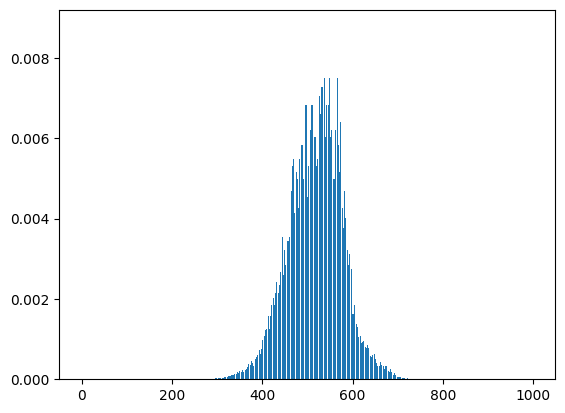

In [28]:
plt.bar(np.arange(1000), ps[500])

OT completion


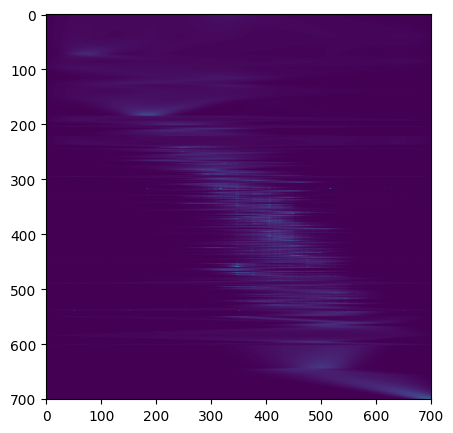

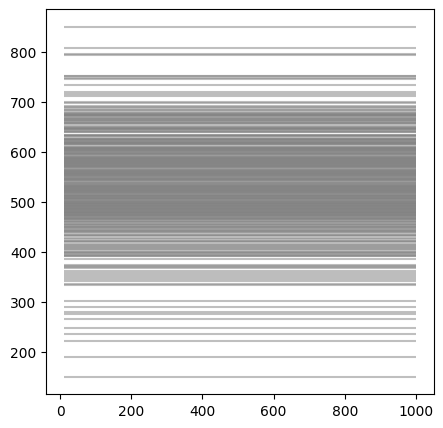

No completion


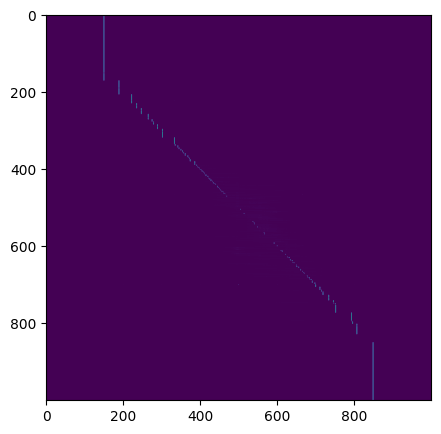

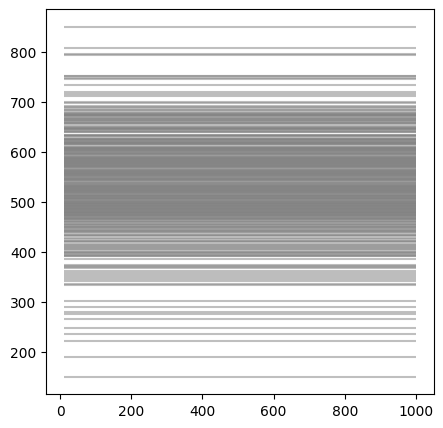

In [38]:
print(f"OT completion")
plt.figure(figsize=(5,5))
plt.imshow(ps[149:850,149:850])
plt.show()

plt.figure(figsize=(5,5))
plot_matrix(hashmap)
plt.show()

print(f"No completion")
plt.figure(figsize=(5,5))
plt.imshow(ps2)
plt.show()

plt.figure(figsize=(5,5))
plot_matrix(hashmap2)
plt.show()

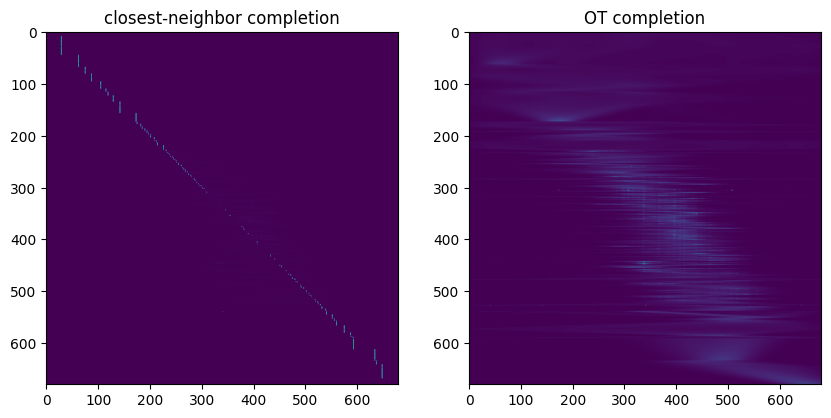

In [68]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(ps2[160:840,160:840])
plt.title("closest-neighbor completion")

plt.subplot(1,2,2)
plt.imshow(ps[160:840,160:840])
plt.title("OT completion")

plt.show()

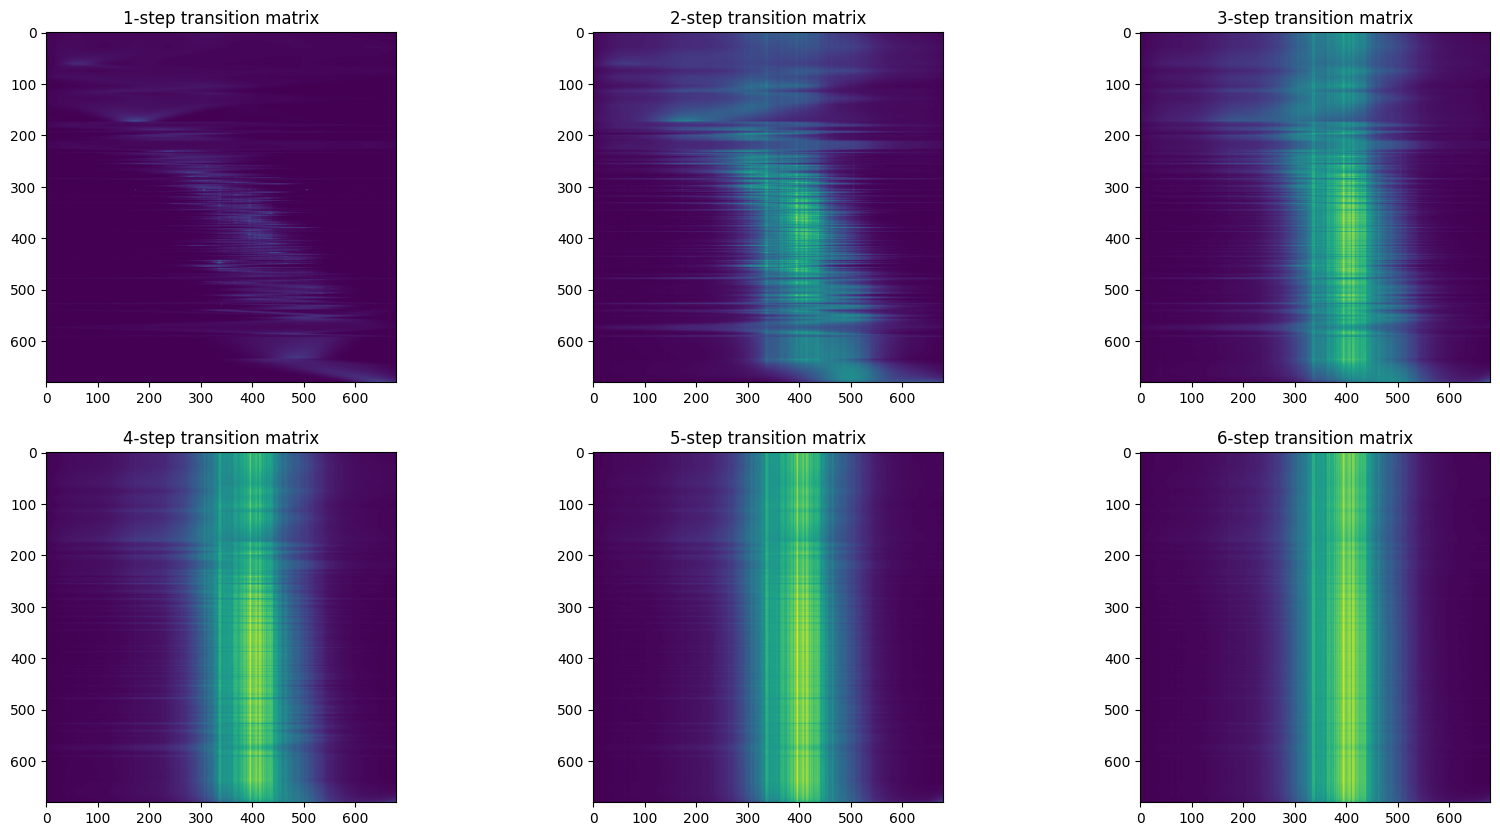

In [67]:
plt.figure(figsize=(20,10))
for power in range(1,7):
    plt.subplot(2,3,power)
    plt.imshow(np.linalg.matrix_power(ps,power)[160:840,160:840])
    plt.title(f"{power}-step transition matrix")
plt.show()

No completion


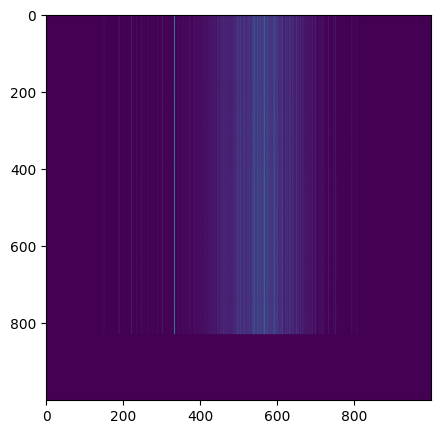

In [43]:
print(f"No completion")
plt.figure(figsize=(5,5))
plt.imshow(np.linalg.matrix_power(ps2,200000))
plt.show()